In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer

Import data

In [3]:
df = pd.read_csv('./data/tennis_cleaned.csv')
df.reset_index(drop=True,inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
df.isnull().sum()

subreddit      0
title          0
selftext       3
created_utc    0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.head()

,subreddit,title,selftext,created_utc
0,tennis,anyone down for a hit in los angeles?,"hey, people! i'm a dude in his late twenty get...",1637458418
1,tennis,zverev on peng shuai?,any word from zverev about peng shuai? not sur...,1637457638
2,tennis,zverev beat djokovic to set up medvedev final ...,[none],1637457620
3,tennis,peng shuai: china block cnn's signal to preven...,[none],1637456757
4,tennis,peng shuai situation explained: chinese state ...,[none],1637454383


In [7]:
# create sentiment scores
sia = SentimentIntensityAnalyzer()
df['sentiment'] = [sia.polarity_scores(x)['compound'] for x in df['title']]
df['sentiment'] = (df['sentiment'] > 0).astype(int)

In [8]:
X = df['title']
y = df['sentiment']

# Check the distribution of our variable.
y.value_counts(normalize=True)

0    0.61222
1    0.38778
Name: sentiment, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
# CountVectorizer

In [11]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [12]:
#logreg

In [13]:
#Instantiate  model.
logreg = LogisticRegression()
logreg.fit(X_train_cvec, y_train)

logreg.predict(X_train_cvec), logreg.score(X_test_cvec, y_test), cross_val_score(logreg, X_train_cvec, y_train).mean()

(array([0, 0, 0, ..., 1, 0, 1]), 0.8558631921824105, 0.8470930918529881)

In [14]:
logreg.coef_

array([[ 0.40679811, -0.5957427 ,  0.18508378, ..., -0.11949393,
        -0.11949393, -0.11949393]])

In [15]:
preds_log = logreg.predict(X_test_cvec)
precision = metrics.precision_score(y_test, preds_log)
recall = metrics.recall_score(y_test, preds_log)
accuracy = metrics.accuracy_score(y_test, preds_log)
accuracy, precision, recall

(0.8558631921824105, 0.8929503916449086, 0.7154811715481172)

In [16]:
metrics.confusion_matrix(y_test, preds_log)

array([[709,  41],
       [136, 342]], dtype=int64)

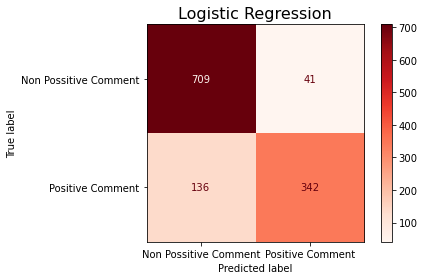

In [17]:
metrics.confusion_matrix(y_test, preds_log)
metrics.plot_confusion_matrix(logreg, X_test_cvec, y_test, cmap='Reds', 
                      values_format='d', display_labels=['Non Possitive Comment', 'Positive Comment'])
plt.title('Logistic Regression', fontsize=16)
plt.savefig('./images/LogReg.png', bbox_inches='tight');

In [18]:
# pipeline

In [19]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', LogisticRegression())
])

In [20]:
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9679521998913634, 0.8509771986970684)

In [21]:
preds_pipe = pipe.predict(X_test)
precision = metrics.precision_score(y_test, preds_pipe)
recall = metrics.recall_score(y_test, preds_pipe)
accuracy = metrics.accuracy_score(y_test, preds_pipe)
accuracy, precision, recall

(0.8509771986970684, 0.8696741854636592, 0.7259414225941423)

In [22]:
metrics.confusion_matrix(y_test, preds_pipe)

array([[698,  52],
       [131, 347]], dtype=int64)

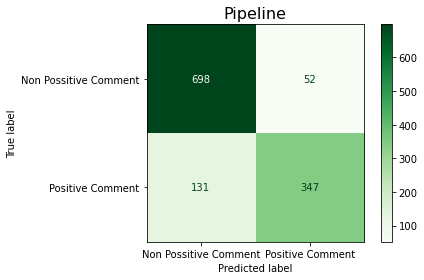

In [23]:
metrics.plot_confusion_matrix(pipe, X_test, y_test, cmap='Greens', 
                      values_format='d', display_labels=['Non Possitive Comment', 'Positive Comment'])
plt.title('Pipeline', fontsize=16)
plt.savefig('./images/pipe.png', bbox_inches='tight');

In [24]:
# Instantiate model.
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_cvec, y_train)
dt.score(X_train_cvec, y_train), dt.score(X_test_cvec, y_test)

(0.9994568169473113, 0.8607491856677525)

In [25]:
grid = {
'max_depth': [2, 3, 5, 7],
'min_samples_split': [5, 10, 15, 20],
'min_samples_leaf': [2, 3, 4, 5, 6],
'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]
}

In [26]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=grid)

In [27]:
gs.fit(X_train_cvec, y_train)
gs.best_params_

{'ccp_alpha': 0, 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 5}

In [28]:
gs.best_score_

0.7555723113680608

In [29]:
gs.score(X_train_cvec, y_train), gs.score(X_test_cvec, y_test)

(0.7599130907115698, 0.746742671009772)

In [30]:
preds_gs = gs.predict(X_test_cvec)
precision = metrics.precision_score(y_test, preds_gs)
recall = metrics.recall_score(y_test, preds_gs)
accuracy = metrics.accuracy_score(y_test, preds_gs)
accuracy, precision, recall

(0.746742671009772, 0.9033816425120773, 0.3912133891213389)

In [31]:
metrics.confusion_matrix(y_test, preds_gs)

array([[730,  20],
       [291, 187]], dtype=int64)

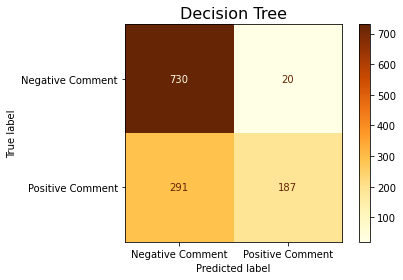

In [32]:
metrics.plot_confusion_matrix(gs, X_test_cvec, y_test, cmap='YlOrBr', 
                      values_format='d', display_labels=['Negative Comment', 'Positive Comment'])
plt.title('Decision Tree', fontsize=16)
plt.savefig('./images/tree.png', bbox_inches='tight');

**Compare Recall/Sensitivity score**

In [33]:
# Recall/Sensitivity, percentage witin those actual positive, how many were predicted positive 
metrics.recall_score(y_test, preds_log), metrics.recall_score(y_test, preds_pipe), metrics.recall_score(y_test, preds_gs)

(0.7154811715481172, 0.7259414225941423, 0.3912133891213389)

**Compare Precision score**

In [34]:
# Precision, percentage within those predicted possitive, how many were correct.
metrics.precision_score(y_test, preds_log), metrics.precision_score(y_test, preds_pipe), metrics.precision_score(y_test, preds_gs)

(0.8929503916449086, 0.8696741854636592, 0.9033816425120773)

**Compare Accuracy score**

In [35]:
# Accuracy, percentae of obervation mode predicted corretly.
metrics.accuracy_score(y_test, preds_log), metrics.accuracy_score(y_test, preds_pipe), metrics.accuracy_score(y_test, preds_gs)

(0.8558631921824105, 0.8509771986970684, 0.746742671009772)

**Compare f1 score**

In [36]:
metrics.f1_score(y_test, preds_log), metrics.f1_score(y_test, preds_pipe), metrics.f1_score(y_test, preds_gs)

(0.794425087108014, 0.7913340935005702, 0.545985401459854)

**ROC AUC score**

In [37]:
# ROC AUC is .92, closest to 1
logreg.score(X_test_cvec, y_test), metrics.roc_auc_score(y_test, logreg.predict_proba(X_test_cvec)[:, 1])

(0.8558631921824105, 0.9180529986052998)

In [38]:
pipe.score(X_test, y_test), metrics.roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])

(0.8509771986970684, 0.9097461645746165)

In [39]:
gs.score(X_test_cvec, y_test), metrics.roc_auc_score(y_test, gs.predict_proba(X_test_cvec)[:, 1])

(0.746742671009772, 0.6834895397489541)

In [40]:
fpreds = logreg.predict(cvec.transform(X))
df['predictions'] = fpreds

**Prediction**

In [41]:
df_p = pd.read_csv('./data/pickleball_cleaned.csv')
df_p.reset_index(drop=True,inplace=True)
df_p.drop(columns=['Unnamed: 0'], inplace=True)

In [42]:
Z = df_p['title']

In [43]:
Zpreds = logreg.predict(cvec.transform(Z))

In [44]:
df_p['predictions'] = Zpreds

In [45]:
df_p.to_csv('./data/pickleball_prediction.csv')

In [46]:
df_p.head(20)

,subreddit,title,selftext,created_utc,predictions
0,pickleball,crazy rule question,[removed],1637457988,0
1,pickleball,43 court-tested pickleball tip to win point (a...,[none],1637445886,1
2,pickleball,phoenix pickleball scene,[removed],1637437159,0
3,pickleball,phoenix pickleball,[removed],1637418798,0
4,pickleball,what's one thing you find most lacking in the ...,"could be something like high quality reviews, ...",1637354289,0
5,pickleball,faster movement,i’ve been playing pickleball for a little over...,1637349733,0
6,pickleball,backyard court questions?,we’re preparing plan for a backyard renovation...,1637281077,0
7,pickleball,pickleball - the fastest growing sport in america,[none],1637250247,0
8,pickleball,what shoe to use?,[removed],1637243112,0
9,pickleball,created a round robin app (ios),"hi, i have just released my round robin app on...",1637223681,0


In [46]:
df['sentiment'].value_counts(normalize=True)

0    0.61222
1    0.38778
Name: sentiment, dtype: float64

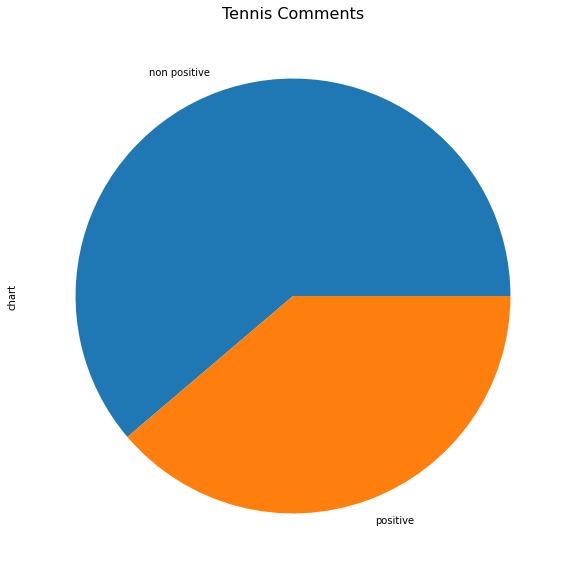

In [47]:
df['chart'] = df['sentiment'].map({0: 'non positive', 1: 'positive'})
plt.figure(figsize=(10, 10))
plt.title('Tennis Comments', fontsize=16)
df['chart'].value_counts(normalize=True).plot(kind='pie');
plt.savefig('./images/tennis_pie.png', bbox_inches='tight');

In [48]:
df_p['predictions'].value_counts(normalize=True) # 10% less possitive comments

0    0.74578
1    0.25422
Name: predictions, dtype: float64

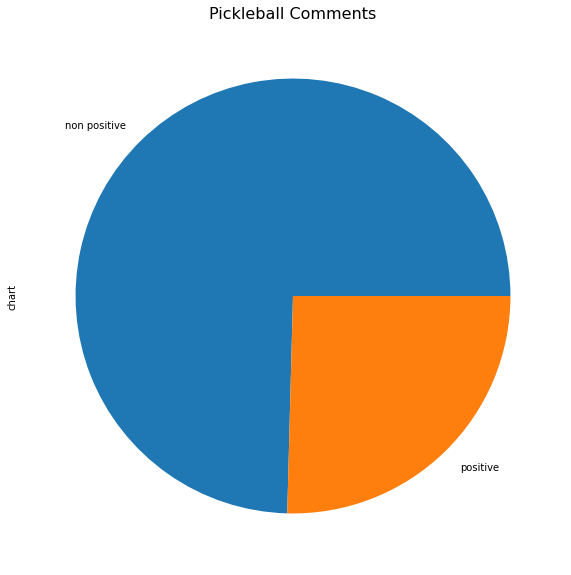

In [49]:
df_p['chart'] = df_p['predictions'].map({0: 'non positive', 1: 'positive'})
plt.figure(figsize=(10, 10))
plt.title('Pickleball Comments', fontsize=16)
df_p['chart'].value_counts(normalize=True).plot(kind='pie');
plt.savefig('./images/pickleball_pie.png', bbox_inches='tight');